In [1]:
# Standard library imports
import os
import math
import itertools
from typing import List, Union, Sequence

# Third-party library imports
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from numpy import ndarray
from tqdm import tqdm
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from torch_geometric.data import Data
from torch_geometric.nn import ChebConv
from torch_geometric.nn.conv import GeneralConv

# Project-specific imports (if any)

### For Now: Grabbing Parts of Pytorch Geometric Temporal As Having Difficulty Setting Up The Environment For It

In [2]:
class DynamicGraphTemporalSignal(object):
    r"""
    Pulled from: 
    https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/torch_geometric_temporal/signal/dynamic_graph_temporal_signal.py
    A data iterator object to contain a dynamic graph with a
    changing edge set and weights . The feature set and node labels
    (target) are also dynamic. The iterator returns a single discrete temporal
    snapshot for a time period (e.g. day or week). This single snapshot is a
    Pytorch Geometric Data object. Between two temporal snapshots the edges,
    edge weights, target matrices and optionally passed attributes might change.

    Args:
        edge_indices (Sequence of Numpy arrays): Sequence of edge index tensors.
        edge_weights (Sequence of Numpy arrays): Sequence of edge weight tensors.
        features (Sequence of Numpy arrays): Sequence of node feature tensors.
        targets (Sequence of Numpy arrays): Sequence of node label (target) tensors.
        **kwargs (optional Sequence of Numpy arrays): Sequence of additional attributes.
    """

    def __init__(
        self,
        edge_indices: Sequence[Union[np.ndarray, None]],
        edge_weights: Sequence[Union[np.ndarray, None]],
        features: Sequence[Union[np.ndarray, None]],
        targets: Sequence[Union[np.ndarray, None]],
        **kwargs: Sequence[np.ndarray]
    ):
        self.edge_indices = edge_indices
        self.edge_weights = edge_weights
        self.features = features
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _check_temporal_consistency(self):
        assert len(self.features) == len(
            self.targets
        ), "Temporal dimension inconsistency."
        assert len(self.edge_indices) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        assert len(self.features) == len(
            self.edge_weights
        ), "Temporal dimension inconsistency."
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.features)

    def _get_edge_index(self, time_index: int):
        if self.edge_indices[time_index] is None:
            return self.edge_indices[time_index]
        else:
            return torch.LongTensor(self.edge_indices[time_index])

    def _get_edge_weight(self, time_index: int):
        if self.edge_weights[time_index] is None:
            return self.edge_weights[time_index]
        else:
            return torch.FloatTensor(self.edge_weights[time_index])

    def _get_features(self, time_index: int):
        if self.features[time_index] is None:
            return self.features[time_index]
        else:
            return torch.FloatTensor(self.features[time_index])

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = DynamicGraphTemporalSignal(
                self.edge_indices[time_index],
                self.edge_weights[time_index],
                self.features[time_index],
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            x = self._get_features(time_index)
            edge_index = self._get_edge_index(time_index)
            edge_weight = self._get_edge_weight(time_index)
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.features):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self

## Set Up BoidDatasetLoader To Load Entire Dataset
Following Example of EnglandCovidDatasetLoader from Pytorch Geometric Temporal

In [3]:
class BoidDatasetLoader(object):
    """
    The BoidDatasetLoader class is designed to load and process the Boid Dataset.
    It reads data from CSV files, processes it, and prepares it for further analysis or modeling. The class performs the
    following key functions:

    1. Initialization (__init__ method):
       - Calls the _read_data method to load and preprocess the data.

    2. Data Reading and Preprocessing (_read_data method):
       - Reads simulation data from 'simulation.csv' and 'simulation_edges.csv'.
       - Drops the 'Simulation' column from both dataframes.
       - Renames columns to standardize the naming convention (e.g., 'Boids' to 'BoidID', 'Boid_i' to 'BoidID_i').
       - Stores the cleaned dataframes in the _dataset attribute.
       - Calls the _process_dataset method to further process the data and extract features, edges, and edge weights.

    3. Dataset Processing (_process_dataset method):
       - Groups the simulation data by 'Timestep'.
       - Initializes lists to store edge indices, node features, and distances.
       - Iterates over each timestep to extract relevant data for that timestep.
       - Converts the dataframes to NumPy arrays for efficient computation.
       - Creates a dictionary to map BoidID to coordinates.
       - Uses vectorized operations to calculate distances between boids with edges.

    4. Getting Features and Edge Weights (_get_edge_weights() and _get_features() methods):
        - Normalized features and _edge_weights using min-max normalization
        - Attributes are now normalized when called and returned

    5. Getting Target (_get_target() method):
        - If t is the current index of our dataset, then t+1 is the target
        - Contains the node features of the graph at t+1
        - Will probably not used this as wouldnt work entirely for more than 1 timestep prediction

    Attributes:
        _dataset: A tuple containing the cleaned simulation data and edge data.
        features: Node features extracted from the simulation data.
        _edges: Edge indices representing connections between boids.
        _edge_weights: Weights of the edges, which could represent distances or other metrics.

    Methods:
        __init__(): Initializes the class and reads the data.
        _read_data(): Reads and preprocesses the data from CSV files.
        _process_dataset(sim_df, sim_edges_df): Processes the dataset to extract features, edges, and edge weights.
    """
    def __init__(self):
        self._read_data()

    def _read_data(self):
        path_to_sim = '../data/simulation.csv'
        path_to_sim_edges = '../data/simulation_edges.csv'
        sim_df = pd.read_csv(path_to_sim)
        sim_edges_df = pd.read_csv(path_to_sim_edges)

        sim_df.drop(columns='Simulation', inplace=True)
        sim_df.rename(columns={'Boids':'BoidID'}, inplace=True)

        sim_edges_df.drop(columns='Simulation', inplace=True)
        sim_edges_df.rename(columns={'Boid_i':'BoidID_i', 'Boid_j':'BoidID_j'}, inplace=True)
        
        self._dataset = (sim_df, sim_edges_df)
        self.features, self._edges, self._edge_weights = self._process_dataset(self._dataset[0], self._dataset[1])

    def _process_dataset(self, sim_df, sim_edges_df):
        # Group the dataframes by 'Timestep'
        sim_grouped = sim_df.groupby('Timestep')
        edges_grouped = sim_edges_df.groupby('Timestep')
        
        # Initialize lists to store edge indices and node features
        edge_indices = []
        node_features = []
        
        distances = []

        # Iterate over each group
        for timestep, _ in sim_grouped:
            # Extract relevant columns for the current timestep
            timestep_df = sim_grouped.get_group(timestep)[['x', 'y', 'dx', 'dy', 'BoidID']]
            timestep_edges_df = edges_grouped.get_group(timestep)[['BoidID_i', 'BoidID_j']]
            
            # Convert dataframes to numpy arrays
            node_array = timestep_df[['x', 'y', 'dx', 'dy']].to_numpy()
            edge_array = timestep_edges_df.to_numpy().T

            # Create a dictionary to map BoidID to coordinates
            boid_coords = {boid_id: coords for boid_id, coords in zip(timestep_df['BoidID'], timestep_df[['x', 'y']].values)}
            
            # Get coordinates for boids involved in edges
            boid_i_coords = np.array([boid_coords[boidid_i] for boidid_i in edge_array[0]])
            boid_j_coords = np.array([boid_coords[boidid_j] for boidid_j in edge_array[1]])
            
            # Calculate distances using vectorized operations
            timestep_distances = np.linalg.norm(boid_i_coords - boid_j_coords, axis=1)
            
            distances.append(timestep_distances)

            # Append the numpy arrays to the respective lists
            edge_indices.append(edge_array)
            node_features.append(node_array)

        # Return the lists of edge indices and node features
        return node_features, edge_indices, distances

    def _compute_feature_min_max(self, feature_list):
        """
        Compute the minimum and maximum of features across all node features.

        Parameters:
        all_node_features (list of np.ndarray): List of numpy arrays containing node features.

        Returns:
        tuple: A tuple containing two numpy arrays: (final_min, final_max).
        """
        if not feature_list:
            raise ValueError("The input list 'all_node_features' is empty.")
        
        # Initialize final_min and final_max with appropriate dimensions
        if len(feature_list[0].shape) == 0:
            raise ValueError('The input list is missing node features') 
        
        if len(feature_list[0].shape) == 1:
            feature_dim = 1
            axis_val = None
            final_min = float('inf')
            final_max = float('-inf')
        else:
            feature_dim = feature_list[0].shape[1]
            axis_val = 0
            final_min = np.array([float('inf')] * feature_dim)
            final_max = np.array([float('-inf')] * feature_dim)
        
        # Iterate through all node features to compute final_min and final_max
        for features in feature_list:
            curr_max = np.max(features, axis=axis_val)
            curr_min = np.min(features, axis=axis_val)
            final_max = np.max(np.array([final_max, curr_max]), axis=0)
            final_min = np.min(np.array([final_min, curr_min]), axis=0)
        
        return final_min, final_max
    
    def _minmax_scale(self, feature_list, final_min, final_max):
        normalized = []
        for i in range(len(feature_list)):
            X = feature_list[i]
            X_std = (X - final_min) / (final_max - final_min)
            normalized.append(X_std)
        return normalized

    def undo_minmax_scale(self, normalized_feature_list, final_min, final_max):
        unnormalized = []
        for i in range(len(normalized_feature_list)):
            X_std = normalized_feature_list[i]
            X_scaled = X_std * (final_max - final_min) + final_min
            unnormalized.append(X_scaled)
        return unnormalized
    

    def _get_edge_weights(self):
        self.min_edge_weight, self.max_edge_weight = self._compute_feature_min_max(self._edge_weights)
        self._edge_weights = self._minmax_scale(self._edge_weights, self.min_edge_weight, self.max_edge_weight)

    def _get_features(self):
        self.min_features, self.max_features = self._compute_feature_min_max(self.features)
        self.features = self._minmax_scale(self.features, self.min_features, self.max_features)
    def _get_targets(self):
        self.targets = [self.features[i] for i in range(1, len(self.features))]


    def get_dataset(self) -> DynamicGraphTemporalSignal:

        self._get_edge_weights()
        self._get_features()
        self._get_targets()
        dataset = DynamicGraphTemporalSignal(
            self._edges[:len(self.features)-1], 
            self._edge_weights[:len(self.features)-1], 
            self.features[:len(self.features)-1], 
            self.targets
        )
        return dataset

In [4]:
loader = BoidDatasetLoader()
dataset = loader.get_dataset()
dataset.snapshot_count

9999

In [ ]:
loader.min_features[0:2], loader.max_features[0:2]

# Split Dataset Into Training and Testing

In [5]:
# Again from https://github.com/benedekrozemberczki/pytorch_geometric_temporal/blob/master/torch_geometric_temporal/signal/train_test_split.py

def temporal_signal_split(data_iterator, train_ratio=0.8):
    train_snapshots = int(data_iterator.snapshot_count * train_ratio)
    train_iterator = data_iterator[0:train_snapshots]
    test_iterator = data_iterator[train_snapshots:]
    return train_iterator, test_iterator

In [6]:
train_dataset, test_dataset = temporal_signal_split(dataset)

train_dataset.snapshot_count, test_dataset.snapshot_count

(7999, 2000)

## Create GConvGRU For Recurrent Layer In Our GNN

In [7]:
class GConvGRU(torch.nn.Module):
    r"""An implementation of the Chebyshev Graph Convolutional Gated Recurrent Unit
    Cell. For details see this paper: `"Structured Sequence Modeling with Graph
    Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(GConvGRU, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.normalization = normalization
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_z = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_r = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_h = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
            #print('You none')
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H, lambda_max):
        #print(X.shape, edge_index.shape, edge_weight.shape, H.shape, self.out_channels)
        Z = self.conv_x_z(X, edge_index, edge_weight, lambda_max=lambda_max)
        Z = Z + self.conv_h_z(H, edge_index, edge_weight, lambda_max=lambda_max)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H, lambda_max):
        R = self.conv_x_r(X, edge_index, edge_weight, lambda_max=lambda_max)
        R = R + self.conv_h_r(H, edge_index, edge_weight, lambda_max=lambda_max)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R, lambda_max):
        H_tilde = self.conv_x_h(X, edge_index, edge_weight, lambda_max=lambda_max)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_weight, lambda_max=lambda_max)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H
    
    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
        lambda_max: torch.Tensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.
            * **lambda_max** *(PyTorch Tensor, optional but mandatory if normalization is not sym)* - Largest eigenvalue of Laplacian.


        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H, lambda_max)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H, lambda_max)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R, lambda_max)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H


## Basic Graph Recurrent Neural Network

In [ ]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 4)

    def forward(self, x, edge_index, edge_weight, H=None):
        h = self.recurrent(x, edge_index, edge_weight, H)
        x = F.relu(h)
        x = self.linear(x)
        return x, h


model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(3):
    for seq_start in tqdm(range(0, train_dataset.snapshot_count - 5, 5)):
        h_t_prev = None
        for i in range(5):
            snapshot = train_dataset[seq_start+i]
            y_hat, h_t = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h_t_prev)
            h_t_prev = h_t
        cost = F.mse_loss(y_hat, snapshot.y)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()


## Training

In [11]:
def train(train_data, num_epochs, model, optimizer, window=8, delay=0, horizon=1, stride=1):
    """
    Trains the given model using the provided training data.

    Args:
        train_data (Dataset): The dataset containing the training data.
        num_epochs (int): The number of epochs to train the model.
        model (nn.Module): The model to be trained.
        optimizer (Optimizer): The optimizer used for training the model.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the training data. Defaults to 1.

    Returns:
        None
    """
    total_timesteps = train_data.snapshot_count
    sample_span = window + delay + horizon

    model.train()
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        epoch_cost = 0 
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Training'):
            input_seq = train_data[start:start + window]
            target_seq = train_data[start + window + delay: start + window + delay + horizon]

            h_t_prev = None
            for i in range(input_seq.snapshot_count):
                snapshot = input_seq[i]
                y_hat, h_t = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h_t_prev)
                h_t_prev = h_t

            cost = torch.mean((y_hat - target_seq[0].x) ** 2)
            epoch_cost += cost.item()
            #print('Loss', cost.item())
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f'Cost after epoch {epoch+1}: {epoch_cost}')

In [ ]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(train_dataset, 10, model, optimizer)

In [18]:
def plot_predictions(y_hat, target_seq, filename):
    """
    Plots the predicted points and the actual points, and saves the plot as an image file.

    Args:
        y_hat (torch.Tensor): The predicted points.
        target_seq (torch_geometric.data.Data): The actual points.
        filename (str): The filename to save the plot.
    """
    y_hat_np = y_hat.detach().cpu().numpy()
    target_np = target_seq[0].x.detach().cpu().numpy()

    loader.min_features[0:2], loader.max_features[0:2]

    plt.figure(figsize=(10, 5))

    # Plot predicted points
    plt.scatter(y_hat_np[:, 0] * (loader.max_features[0] - loader.min_features[0]) + loader.min_features[0], 
                y_hat_np[:, 1] * (loader.max_features[1] - loader.min_features[1]) + loader.min_features[1], color='r', label='Predicted', alpha=0.6)

    # Plot actual points
    plt.scatter(target_np[:, 0] * (loader.max_features[0] - loader.min_features[0]) + loader.min_features[0], 
                target_np[:, 1] * (loader.max_features[1] - loader.min_features[1]) + loader.min_features[1], color='b', label='Actual', alpha=0.6)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((0,1000))
    plt.ylim((0,1000))
    plt.legend()
    plt.title('Predicted vs Actual Points')
    plt.savefig(filename)
    plt.close()

def test(test_data, model, window=8, delay=0, horizon=1, stride=1, output_dir='../plots'):
    """
    Tests the given model using the provided test data and saves the plots as images.

    Args:
        test_data (Dataset): The dataset containing the test data.
        model (nn.Module): The model to be tested.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the test data. Defaults to 1.
        output_dir (str, optional): The directory to save the plots. Defaults to 'plots'.

    Returns:
        float: The average loss over the test dataset.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    total_timesteps = test_data.snapshot_count
    sample_span = window + delay + horizon

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride)):
            input_seq = test_data[start:start + window]
            target_seq = test_data[start + window + delay: start + window + delay + horizon]

            h_t_prev = None
            for i in range(input_seq.snapshot_count):
                snapshot = input_seq[i]
                y_hat, h_t = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h_t_prev)
                h_t_prev = h_t

            cost = torch.mean((y_hat - target_seq[0].x) ** 2)
            total_loss += cost.item()

            # Save the plot
            filename = os.path.join(output_dir, f'plot_{start}.png')
            plot_predictions(y_hat, target_seq, filename)

    average_loss = total_loss / (total_timesteps - sample_span + 1)
    return average_loss

# Example usage
# average_loss = test(test_data, model)

In [ ]:
test(test_dataset, model)

In [38]:
import cv2
import os
import re

def create_video_from_images(image_folder, output_video_path, fps=30):
    # Get list of images in the folder
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    def extract_number(filename):
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else -1
    images.sort(key=extract_number)  # Ensure the images are in the correct order

    # Read the first image to get the dimensions
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width = frame.shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use other codecs as well
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    # Release the video writer object
    video.release()

# Example usage
create_video_from_images('../generator_test_plots_at_epoch_30', 'generator_test_plots_at_epoch_30.mp4', fps=30)

## Working on GAN [Generator: (Encoder, Decoder)] [Discriminator: (Encoder)]

In [8]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, k=2):
        super(Encoder, self).__init__()
        self.recurrent = GConvGRU(input_dim, hidden_dim, k)
        self.linear = torch.nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x, edge_index, edge_weight, h):
        h_0 = self.recurrent(x, edge_index, edge_weight, h)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0 # Output = (latent matrix, hidden state for encoder)

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, k=2):
        super(Decoder, self).__init__()
        self.recurrent = GConvGRU(latent_dim, hidden_dim, k)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_weight, h):
        h_0 = self.recurrent(z, edge_index, edge_weight, h)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0 # Output = (Final Output, hidden state for decoder)

In [9]:
class GraphSeqGenerator(torch.nn.Module):
    def __init__(self, node_feat_dim, enc_hidden_dim, enc_latent_dim, dec_hidden_dim, pred_horizon, min_max_x, min_max_y, min_max_edge_weight, visualRange):
        super(GraphSeqGenerator, self).__init__()
        self.encoder = Encoder(node_feat_dim, enc_hidden_dim, enc_latent_dim)
        self.decoder = Decoder(enc_latent_dim, dec_hidden_dim, node_feat_dim)
        self.out_steps = pred_horizon
        self.min_x, self.max_x = min_max_x
        self.min_y, self.max_y = min_max_y
        self.min_edge_weight, self.max_edge_weight = min_max_edge_weight
        self.visualRange = visualRange

    def _compute_edge_index_and_weight(self, y_hat):
        # Not designed for batches :/
        # Grab x and y features
        y_hat_x = y_hat[:, 0].detach().numpy()
        y_hat_y = y_hat[:, 1].detach().numpy()

        # Undo normalization
        y_hat_x = y_hat_x * (self.max_x - self.min_x) + self.min_x
        y_hat_y = y_hat_y * (self.max_y - self.min_y) + self.min_y

        # Compute the distance of all points and include that edge if its less than visualRange
        coords = np.stack((y_hat_x, y_hat_y), axis=1)
        dist_matrix = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2)
        
        # Get indices where distance is less than visualRange
        edge_indices = np.where((dist_matrix < self.visualRange) & (dist_matrix > 0))
        
        # Create edge_index and edge_attr
        edge_index = np.vstack((edge_indices[0], edge_indices[1]))
        edge_weight = dist_matrix[edge_indices]

        #Normalize edge_weight
        edge_weight = (edge_weight - self.min_edge_weight) / (self.max_edge_weight - self.min_edge_weight)
        
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        return edge_index, edge_weight


        
    def forward(self, sequence, h_enc, h_dec):
        # Warmup Section
        for i in range(sequence.snapshot_count):
            snapshot = sequence[i]
            z, h_enc_0 = self.encoder(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h_enc)
            y_hat, h_dec_0 = self.decoder(z, snapshot.edge_index, snapshot.edge_weight, h_dec)

            h_enc = h_enc_0
            h_dec = h_dec_0

        predictions = []
        predictions.append(y_hat)

        # Prediction Section
        for _ in range(self.out_steps-1):
            # TODO: Compute edge index and edge_attr of y_hat :()
            y_hat_edge_index, y_hat_edge_attr = self._compute_edge_index_and_weight(y_hat)

            z, h_enc_0 = self.encoder(y_hat, y_hat_edge_index, y_hat_edge_attr, h_enc)
            y_hat, h_dec_0 = self.decoder(z, y_hat_edge_index, y_hat_edge_attr, h_dec)

            predictions.append(y_hat)
        return predictions

In [42]:
generator = generator = GraphSeqGenerator(node_feat_dim=4,
                              enc_hidden_dim=32,
                              enc_latent_dim=16,
                              dec_hidden_dim=32,
                              pred_horizon=8,
                              min_max_x=(loader.min_features[0], loader.max_features[0]),
                              min_max_y=(loader.min_features[1], loader.max_features[1]),
                              min_max_edge_weight=(loader.min_edge_weight, loader.max_edge_weight),
                              visualRange=75,
                            )

device = torch.device('cpu')

generator.to(device)

GraphSeqGenerator(
  (encoder): Encoder(
    (recurrent): GConvGRU(
      (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
      (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
    )
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (recurrent): GConvGRU(
      (conv_x_z): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_r): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
      (conv_x_h): ChebConv(16, 32, K=2, normalization=sym)
      (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
    )
    (linear): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [11]:
def train_generator(train_data, num_epochs, generator, optimizer, window=8, delay=0, horizon=1, stride=1):
    """
    Trains the given model using the provided training data.

    Args:
        train_data (Dataset): The dataset containing the training data.
        num_epochs (int): The number of epochs to train the model.
        model (nn.Module): The model to be trained.
        optimizer (Optimizer): The optimizer used for training the model.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the training data. Defaults to 1.

    Returns:
        None
    """
    total_timesteps = train_data.snapshot_count
    sample_span = window + delay + horizon

    generator.train()
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        epoch_cost = 0
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Training'):
            input_seq = train_data[start:start + window]
            target_seq = train_data[start + window + delay: start + window + delay + horizon]
            predictions = generator(input_seq, None, None)
            predictions = torch.stack(predictions, dim=0)
            target_seq = torch.stack([target_seq[i].x for i in range(target_seq.snapshot_count)], dim=0)
            cost = torch.mean((predictions - target_seq) ** 2)
            epoch_cost += cost.item()
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(f'Cost after epoch {epoch+1}: {epoch_cost}')

In [16]:
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

train_generator(train_dataset, 10, generator, optimizer, horizon=generator.out_steps)

Epoch: 1/10


Training:  53%|█████▎    | 4268/7984 [06:40<05:48, 10.66it/s]


KeyboardInterrupt: 

In [39]:
def test_generator(test_data, generator, window=8, delay=0, horizon=1, stride=1):
    """
    Tests the given generator model using the provided test data.

    Args:
        test_data (Dataset): The dataset containing the test data.
        generator (nn.Module): The generator model to be tested.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the test data. Defaults to 1.

    Returns:
        float: The average loss over the test dataset.
    """
    total_timesteps = test_data.snapshot_count
    sample_span = window + delay + horizon

    generator.eval()
    total_loss = 0
    with torch.no_grad():
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Testing'):
            input_seq = test_data[start:start + window]
            target_seq = test_data[start + window + delay: start + window + delay + horizon]
            predictions = generator(input_seq, None, None)
            predictions = torch.stack(predictions, dim=0)
            target_seq = torch.stack([target_seq[i].x for i in range(target_seq.snapshot_count)], dim=0)
            cost = torch.mean((predictions - target_seq) ** 2)
            total_loss += cost.item()

    average_loss = total_loss / (total_timesteps - sample_span + 1)
    print('Testing Loss: ', average_loss)
    return average_loss


In [17]:
test_generator(test_dataset, generator, horizon=generator.out_steps)

NameError: name 'test_generator' is not defined

In [24]:
def test_generator_plot(test_data, generator, window=8, delay=0, horizon=1, stride=1, boid_indices=[0,1,2,3, 4, 5]):
    """
    Tests the given generator model using the provided test data and plots the trajectories.

    Args:
        test_data (Dataset): The dataset containing the test data.
        generator (nn.Module): The generator model to be tested.
        window (int, optional): The size of the input sequence window. Defaults to 8.
        delay (int, optional): The delay between the input sequence and the target sequence. Defaults to 0.
        horizon (int, optional): The prediction horizon. Defaults to 1.
        stride (int, optional): The stride for iterating over the test data. Defaults to 1.
        boid_indices (list, optional): List of boid indices to plot. Defaults to [0, 1, 2].

    Returns:
        None
    """
    total_timesteps = test_data.snapshot_count
    sample_span = window + delay + horizon

    generator.eval()
    with torch.no_grad():
        for start in tqdm(range(0, total_timesteps - sample_span + 1, stride), desc='Testing'):
            input_seq = test_data[start:start + window]
            target_seq = test_data[start + window + delay: start + window + delay + horizon]
            predictions = generator(input_seq, None, None)
            predictions = torch.stack(predictions, dim=0)
            target_seq = torch.stack([target_seq[i].x for i in range(target_seq.snapshot_count)], dim=0)
    
            boids_history = []
            boids_future = []
            boids_pred_future = []
            for boid_idx in boid_indices:
                boid_idx_actual_x = [target_seq[i, boid_idx, 0].item() for i in range(target_seq.shape[0])]
                boid_idx_actual_y = [target_seq[i, boid_idx, 1].item() for i in range(target_seq.shape[0])]
                boid_idx_pred_x = [pred[boid_idx, 0].item() for pred in predictions]
                boid_idx_pred_y = [pred[boid_idx, 1].item() for pred in predictions]
                boid_idx_hist_x = [input_seq[i].x[boid_idx, 0].item() for i in range(input_seq.snapshot_count)]
                boid_idx_hist_y = [input_seq[i].x[boid_idx, 1].item() for i in range(input_seq.snapshot_count)]

                boids_history.append((boid_idx_hist_x, boid_idx_hist_y))
                boids_future.append((boid_idx_actual_x, boid_idx_actual_y))
                boids_pred_future.append((boid_idx_pred_x, boid_idx_pred_y))

            def plot_boid_trajectories(boid_indices, boids_history, boids_future, boids_pred_future):
                """
                Plots the actual paths vs the predicted paths for the given boid indices.

                Args:
                    boid_indices (list): List of boid indices to plot.
                    boids_history (list): List of tuples containing historical x and y coordinates for each boid.
                    boids_future (list): List of tuples containing actual future x and y coordinates for each boid.
                    boids_pred_future (list): List of tuples containing predicted future x and y coordinates for each boid.

                Returns:
                    None
                """
                plt.figure(figsize=(10, 5))
                for i, boid_idx in enumerate(boid_indices):
                    hist_x, hist_y = boids_history[i]
                    actual_x, actual_y = boids_future[i]
                    pred_x, pred_y = boids_pred_future[i]

                    plt.plot(hist_x, hist_y, label=f'Boid {boid_idx} History', linestyle='-', marker='o', alpha=0.7)
                    plt.plot(actual_x, actual_y, label=f'Boid {boid_idx} Actual Future', linestyle='-', marker='o', color='blue', alpha=0.7)
                    plt.plot(pred_x, pred_y, label=f'Boid {boid_idx} Predicted Future', linestyle='-', marker='^', color='red', alpha=0.7)

                plt.xlabel('x')
                plt.ylabel('y')
                plt.title('Boid Trajectories')
                plt.show()

            # Call the function to plot the trajectories
            plot_boid_trajectories(boid_indices, boids_history, boids_future, boids_pred_future)


Testing:   0%|          | 0/1985 [00:00<?, ?it/s]

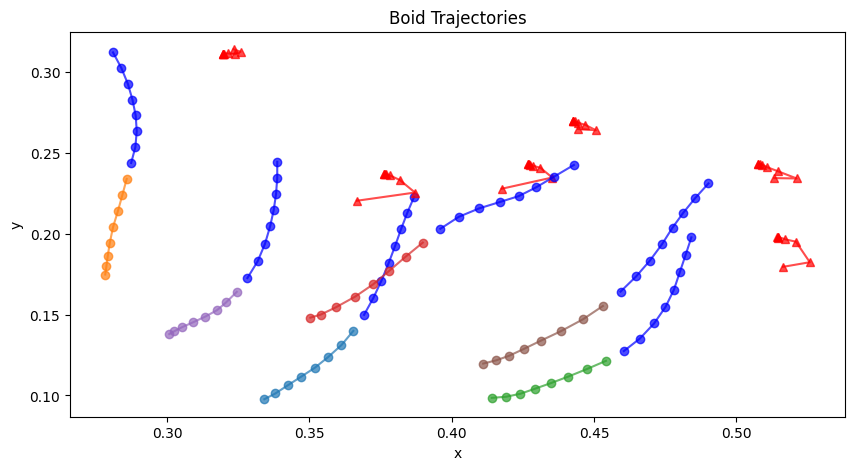

Testing:   0%|          | 1/1985 [00:00<04:48,  6.87it/s]

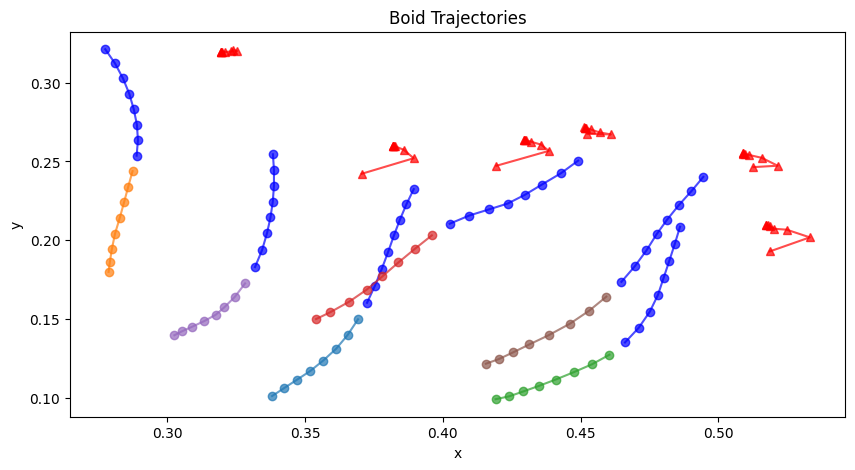

Testing:   0%|          | 2/1985 [00:00<05:46,  5.72it/s]


KeyboardInterrupt: 

In [25]:
test_generator_plot(test_dataset, generator, horizon=generator.out_steps)

In [ ]:
class GraphSeqDiscriminator(torch.nn.Module):
    def __init__(self, node_feat_dim, enc_hidden_dim, enc_latent_dim):
        super(GraphSeqDiscriminator, self).__init__()

        self.encoder = Encoder(node_feat_dim, enc_hidden_dim, enc_latent_dim)
        self.linear = torch.nn.Linear(enc_latent_dim, 1)

    def forward(self, x, edge_index, edge_weight, h):
        z, h_enc_0 = self.encoder(x, edge_index, edge_weight, h)
        z = F.relu(z)

        # Apply global mean pooling across the node dimension (dim=0) to aggregate node features
        z_pooled = z.mean(dim=0)
        out = self.linear(z_pooled)
        out = torch.sigmoid(z_pooled)
        return out, h_enc_0

Epoch: 1/30


Testing: 100%|██████████| 1989/1989 [01:45<00:00, 18.78it/s]


Testing Loss:  0.2572775994071174


Training:  13%|█▎        | 1045/7988 [00:54<06:01, 19.19it/s]


KeyboardInterrupt: 